# Natural Language Processing

O objetivo deste notebook é a criação de um modelo de Machine Learning de análise de sentimento (classificação) utilizado o processamento de linguagem natural. O modelo irá classificar os comentários em três classes: "Positivo", "Negativo" e "Neutro". A primeira tentativa de desenvolvimento do modelo NLP (1_analise_sentimento) obteve métricas muito ruins para a classe "Neutro", devido este fato vamos testar um novo caminho, utilizaremos o processo de Lemmatization em vez de Stemming. Também será aplicado o processo de Filtro Pos Tag e técnicas de UnderSampling.

## 1. Importando Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import spacy
from nltk import tokenize, RSLPStemmer, FreqDist, tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.lm import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from string import punctuation
from time import time
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from gensim.models.word2vec import Word2Vec
from collections import defaultdict
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import LabelEncoder
from yellowbrick.classifier import PrecisionRecallCurve
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler


from utils.regex_utils import *
from utils.stopword_utils import RemoverStopwords
from utils.normalize_utils import ProcessoNormalizacao
from utils.stemming_utils import ProcessoStemming
from utils.lemmatization_utils import ProcessoLemmatization
from utils.features_extract import ExtracaoFeatures, E2V_IDF, extract_features_from_corpus, cut_off
from utils.n_grams_utils import ngrams_count
from utils.wordcloud_utils import nuvem_palavras
from utils.select_model_utils import print_score_BayesSearchCV, print_score
from utils.word2vec_utils import E2V_IDF
from utils.pos_tag_filter_utils import ProcessoFilterPosTag

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Leitura dos dados

In [2]:
dataset = pd.read_csv('order_reviews.csv', sep=';')
dataset.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## 3. Compreensão de dados

In [3]:
dataset.drop(['review_id', 'review_creation_date', 'review_answer_timestamp', 'review_comment_title', 'order_id'], axis=1, inplace=True)

# Retirando o valores Null de reviews
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)
dataset.shape

(40977, 2)

In [4]:
dataset.head()

,review_score,review_comment_message
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


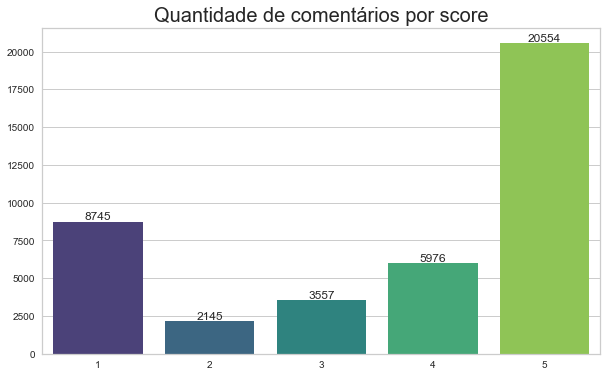

In [5]:
# Criando um datafrem que contem as quantidade de acordo com o score
quantidade = pd.DataFrame(dataset['review_score'].value_counts()).sort_index()

# plotando o gráfico de barra
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(y='review_score', x=quantidade.index, data=quantidade, orient='v', palette='viridis')
ax.set_title('Quantidade de comentários por score', fontdict={'fontsize': 20})
ax.set(ylabel=None, xlabel=None)
ax.bar_label(ax.containers[0])
plt.show()

In [6]:
# Rotulagem dos dados
score_map = {
    1: -1,
    2: -1,
    3: 0,
    4: 1,
    5: 1
}

dataset['sentiment_label'] = dataset['review_score'].map(score_map)
dataset = dataset[['review_score', 'sentiment_label','review_comment_message']]
dataset.head()

,review_score,sentiment_label,review_comment_message
0,5,1,Recebi bem antes do prazo estipulado.
1,5,1,Parabéns lojas lannister adorei comprar pela I...
2,4,1,aparelho eficiente. no site a marca do aparelh...
3,4,1,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,1,"Vendedor confiável, produto ok e entrega antes..."


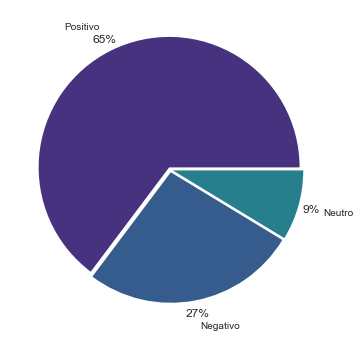

In [7]:
sentiment = pd.DataFrame(dataset['sentiment_label'].value_counts())
labels = ['Positivo', 'Negativo', 'Neutro']

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('viridis')
ax.pie(sentiment['sentiment_label'],labels= labels,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, explode = [0.02, 0.02, 0.02], colors=colors)
plt.show()

## 5. Aplicando Lemmatization aos reviews

A Lemmatization buscar reduzir a palavra à sua raiz, retirando todas as inflexões e chegando ao lemma. Porém, essa redução sempre resultará em uma palavra que realmente existe na gramática. Outro ponto importante é que, nessa técnica, a classe gramatical da palavra será levada em consideração para fazer a redução;

In [8]:
# definindo X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values


# Definindo todas as trafomações regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}


# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('lemmatization', ProcessoLemmatization())
])

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

Salvando os dados processados em um arquivo .csv:

In [9]:
dataset['review_lemma'] = X_processed
dataset.to_csv('order_review_lemma.csv', sep=';', index=False)

Lendo os novos dados criados a partir da Lemmatization:

In [2]:
dataset = pd.read_csv('datasets/order_review_lemma.csv', sep=';')
dataset.head()

,review_score,sentiment_label,review_comment_message,review_lemma
0,5,1,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipular
1,5,1,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,parabem loja lannister adorei comprar Internet seguro pratico parabem todo feliz pascoa
2,4,1,aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho,aparelho eficiente site marca aparelho impresso numero desinfector chegar outro nome atualizar marca correto vez aparelho
3,4,1,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travar valor ta bom
4,5,1,"Vendedor confiável, produto ok e entrega antes do prazo.",vendedor confiavel produto ok entregar antes prazo


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40977 entries, 0 to 40976
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            40977 non-null  int64 
 1   sentiment_label         40977 non-null  int64 
 2   review_comment_message  40977 non-null  object
 3   review_lemma            40817 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.3+ MB


In [3]:
dataset[dataset['review_lemma'].isna()]

,review_score,sentiment_label,review_comment_message,review_lemma
125,5,1,A,NaN
409,4,1,*******************,NaN
1025,1,-1,A,NaN
1411,5,1,. .,NaN
1426,4,1,**,NaN
...,...,...,...,...
38888,5,1,.,NaN
39117,5,1,........................,NaN
39974,5,1,👍🏻👌🏻👏🏻,NaN
40302,4,1,-,NaN


In [3]:
dataset = dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40817 entries, 0 to 40976
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            40817 non-null  int64 
 1   sentiment_label         40817 non-null  int64 
 2   review_comment_message  40817 non-null  object
 3   review_lemma            40817 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.6+ MB


### 5.1 Criando um modelo de LogisticRegressor com a nova base de dados

#### 5.5.1. Removendo apenas as palavras que aparecem menos 15x no dataset

In [6]:
# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15)     
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['review_lemma'], vectorizer, df=True)
print(f'Shape: {df_corpus_features.shape}')
df_corpus_features

Shape: (40817, 1367)


,2e,abaixo,abraco,abri,abril,abrir,absurdo,acabado,acabamento,acabar,...,voce,volta,voltagem,voltar,voltarar,volume,whey,xl,zero,ziper
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.8179932699628099
              precision    recall  f1-score   support

    negativo       0.77      0.86      0.81      3627
      neutro       0.33      0.07      0.11      1182
    positivo       0.89      0.94      0.92      8797

    accuracy                           0.84     13606
   macro avg       0.66      0.62      0.61     13606
weighted avg       0.81      0.84      0.82     13606

f1_score: 0.8157087001744793
              precision    recall  f1-score   support

    negativo       0.76      0.86      0.81      3626
      neutro       0.30      0.05      0.09      1183
    positivo       0.89      0.94      0.92      8797

    accuracy                           0.84     13606
   macro avg       0.65      0.62      0.61     13606
weighted avg       0.81      0.84      0.82     13606

f1_score: 0.8128642269295114
              precision    recall  f1-score   support

    negativo       0.76      0.87      0.81      3626
      neutro       0.28      0.05      0.0

#### 5.5.2. Removendo as palavras que aparecem menos 15x no dataset e mais 10% das palavras que menos aparecem no dataset

In [8]:
# Selecionando 10% das palavras que menos aparecem
stop_words = cut_off(dataset['review_lemma'], 0.1)

# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15, stop_words=stop_words)
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['review_lemma'], vectorizer, df=True)

# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.8191399150387452
              precision    recall  f1-score   support

    negativo       0.77      0.86      0.81      3627
      neutro       0.34      0.07      0.11      1182
    positivo       0.89      0.94      0.92      8797

    accuracy                           0.85     13606
   macro avg       0.67      0.62      0.61     13606
weighted avg       0.81      0.85      0.82     13606

f1_score: 0.8161398565603563
              precision    recall  f1-score   support

    negativo       0.76      0.86      0.81      3626
      neutro       0.31      0.05      0.09      1183
    positivo       0.89      0.94      0.92      8797

    accuracy                           0.84     13606
   macro avg       0.65      0.62      0.61     13606
weighted avg       0.81      0.84      0.82     13606

f1_score: 0.8128511518201368
              precision    recall  f1-score   support

    negativo       0.76      0.87      0.81      3626
      neutro       0.29      0.05      0.0

#### 5.5.2. Removendo as palavras que aparecem menos 15x, 10% das palavras que menos aparecem e 10% que mais aparecem no dataset

In [12]:
# Selecionando 10% das palavras que menos aparecem
stop_words_menos = cut_off(dataset['review_lemma'], 0.1)

# Selecionando 10% das palavras que mais aparecem
stop_words_mais = cut_off(dataset['review_lemma'], 0.1, False)

# Realizando a junção das duas listas
stop_words = stop_words_menos + stop_words_mais

# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15, stop_words=stop_words)
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['review_lemma'], vectorizer, df=True)

# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))


f1_score: 0.7359043899474964
              precision    recall  f1-score   support

    negativo       0.71      0.61      0.66      3627
      neutro       0.30      0.03      0.06      1182
    positivo       0.80      0.94      0.86      8797

    accuracy                           0.77     13606
   macro avg       0.60      0.53      0.52     13606
weighted avg       0.73      0.77      0.74     13606

f1_score: 0.7356253556909146
              precision    recall  f1-score   support

    negativo       0.70      0.61      0.65      3626
      neutro       0.34      0.04      0.06      1183
    positivo       0.80      0.94      0.86      8797

    accuracy                           0.77     13606
   macro avg       0.61      0.53      0.53     13606
weighted avg       0.73      0.77      0.74     13606

f1_score: 0.734416040982246
              precision    recall  f1-score   support

    negativo       0.70      0.62      0.66      3626
      neutro       0.27      0.03      0.05

## 6. Aplicando Filtro Pos Tag aos reviews

### 6.1. Removendo Verbos

In [ ]:
# definindo X e y 
comentarios = dataset['review_lemma'].index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_lemma'][comentarios].values)
y = score.values

# Criando o Pipeline
text_pipeline = Pipeline([
    ('filter_pos_tag', ProcessoFilterPosTag(("VERB")))
])

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

In [3]:
# definindo X e y 
comentarios = dataset['review_comment_message'].index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Definindo todas as trafomações regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}


# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('filter_pos_tag', ProcessoFilterPosTag(("VERB")))  # O filtro ProcessoFilterPosTag possui o processo de lemmatização 
])

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

Salvando o novo tratamento em um novo arquivo .csv:

In [4]:
dataset['filter_pos_tag_verb'] = X_processed
dataset.to_csv('datasets/order_review_filter_pos_tag_verb.csv', sep=';', index=False)

In [13]:
# Carregando o arquivo salvo
dataset = pd.read_csv('datasets/order_review_filter_pos_tag_verb.csv', sep=';')
dataset.head()

,review_score,sentiment_label,review_comment_message,review_lemma,filter_pos_tag_verb
0,5,1,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipular,bem antes prazo
1,5,1,Parabéns lojas lannister adorei comprar pela I...,parabem loja lannister adorei comprar Internet...,parabem loja lannister Internet seguro pratico...
2,4,1,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente site marca aparelho impress...,aparelho eficiente site marca aparelho numero ...
3,4,1,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travar valor ta bom,pouco valor ta bom
4,5,1,"Vendedor confiável, produto ok e entrega antes...",vendedor confiavel produto ok entregar antes p...,vendedor confiavel produto ok antes prazo


In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40817 entries, 0 to 40816
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            40817 non-null  int64 
 1   sentiment_label         40817 non-null  int64 
 2   review_comment_message  40817 non-null  object
 3   review_lemma            40817 non-null  object
 4   review_filter_pos_tag   39894 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


In [23]:
dataset[dataset['review_filter_pos_tag'].isna()]

,review_score,sentiment_label,review_comment_message,review_lemma,review_filter_pos_tag
26,5,1,"Amei achei lindo ,muito delicado adorei",ameir achar lir delicar adorei,NaN
55,3,0,Gostei,gostar,NaN
65,5,1,Gostei da atenção com a entrega,gostar atencao entregar,NaN
67,1,-1,A peça não serviu,pecar negacao servir,NaN
187,5,1,Gostei!,gostar,NaN
...,...,...,...,...,...
40674,4,1,o filho gostou,filho gostar,NaN
40694,5,1,amei,ameir,NaN
40711,5,1,Lindo recomendo !,lir recomendo,NaN
40760,1,-1,"Meus pedidos estão dando como entregues , mais...",pedido dar entregar negacao recebi luminar,NaN


In [14]:
dataset = dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39881 entries, 0 to 40976
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            39881 non-null  int64 
 1   sentiment_label         39881 non-null  int64 
 2   review_comment_message  39881 non-null  object
 3   review_lemma            39881 non-null  object
 4   filter_pos_tag_verb     39881 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


#### 6.1.1. Criando um modelo de LogisticRegressor com a nova base de dados

##### 6.1.1.1. Removendo apenas as palavras que aparecem menos 15x no dataset

In [16]:
# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15) 
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['filter_pos_tag_verb'], vectorizer, df=True)
print(f'Shape: {df_corpus_features.shape}')
df_corpus_features

Shape: (39881, 994)


,2e,abaixo,abraco,abri,abril,absurdo,acabado,acabamento,acessivel,acesso,...,virtual,vivo,voce,volta,voltagem,voltar,volume,whey,xl,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.7899649782525336
              precision    recall  f1-score   support

    negativo       0.75      0.79      0.77      3587
      neutro       0.28      0.03      0.06      1157
    positivo       0.86      0.94      0.90      8550

    accuracy                           0.82     13294
   macro avg       0.63      0.59      0.58     13294
weighted avg       0.78      0.82      0.79     13294

f1_score: 0.7879802652972179
              precision    recall  f1-score   support

    negativo       0.72      0.83      0.77      3587
      neutro       0.34      0.03      0.06      1158
    positivo       0.87      0.92      0.89      8549

    accuracy                           0.82     13294
   macro avg       0.64      0.59      0.58     13294
weighted avg       0.78      0.82      0.79     13294

f1_score: 0.7846394118621727
              precision    recall  f1-score   support

    negativo       0.73      0.80      0.76      3587
      neutro       0.24      0.03      0.0

##### 6.1.1.2. Removendo as palavras que aparecem menos 15x no dataset e mais 10% das palavras que menos aparecem no dataset

In [18]:
# Selecionando 10% das palavras que menos aparecem
stop_words = cut_off(dataset['filter_pos_tag_verb'], 0.1)

# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15, stop_words=stop_words)
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['filter_pos_tag_verb'], vectorizer, df=True)

# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.7891149463978826
              precision    recall  f1-score   support

    negativo       0.75      0.79      0.77      3587
      neutro       0.28      0.03      0.06      1157
    positivo       0.86      0.94      0.90      8550

    accuracy                           0.82     13294
   macro avg       0.63      0.59      0.58     13294
weighted avg       0.78      0.82      0.79     13294

f1_score: 0.7869419554590694
              precision    recall  f1-score   support

    negativo       0.72      0.83      0.77      3587
      neutro       0.33      0.03      0.06      1158
    positivo       0.87      0.92      0.89      8549

    accuracy                           0.82     13294
   macro avg       0.64      0.59      0.57     13294
weighted avg       0.78      0.82      0.79     13294

f1_score: 0.784810925806612
              precision    recall  f1-score   support

    negativo       0.73      0.80      0.77      3587
      neutro       0.26      0.03      0.05

#### 6.1.1.3. Removendo as palavras que aparecem menos 15x, 10% das palavras que menos aparecem e 10% que mais aparecem no dataset

In [19]:
# Selecionando 10% das palavras que menos aparecem
stop_words_menos = cut_off(dataset['filter_pos_tag_verb'], 0.1)

# Selecionando 10% das palavras que mais aparecem
stop_words_mais = cut_off(dataset['filter_pos_tag_verb'], 0.1, False)

# Realizando a junção das duas listas
stop_words = stop_words_menos + stop_words_mais

# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15, stop_words=stop_words)
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['filter_pos_tag_verb'], vectorizer, df=True)

# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.7108870622602544
              precision    recall  f1-score   support

    negativo       0.69      0.54      0.60      3587
      neutro       0.29      0.03      0.05      1157
    positivo       0.77      0.94      0.85      8550

    accuracy                           0.75     13294
   macro avg       0.58      0.50      0.50     13294
weighted avg       0.71      0.75      0.71     13294

f1_score: 0.704287205278633
              precision    recall  f1-score   support

    negativo       0.67      0.54      0.60      3587
      neutro       0.30      0.01      0.03      1158
    positivo       0.77      0.93      0.84      8549

    accuracy                           0.74     13294
   macro avg       0.58      0.49      0.49     13294
weighted avg       0.70      0.74      0.70     13294

f1_score: 0.7058694453563956
              precision    recall  f1-score   support

    negativo       0.67      0.54      0.60      3587
      neutro       0.26      0.02      0.04

### 6.2. Selecionando as palavras que pertecem as classes ("NOUN", "ADJ","ADV")

In [20]:
# definindo X e y 
comentarios = dataset['review_comment_message'].index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Definindo todas as trafomações regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}


# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('filter_pos_tag', ProcessoFilterPosTag(("NOUN", "ADJ", "ADV"), 'in'))  # O filtro ProcessoFilterPosTag possui o processo de lemmatização 
])

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

In [21]:
dataset['filter_pos_tag_noun_adj'] = X_processed
dataset.to_csv('datasets/order_review_filter_pos_tag_noun_adj_adv.csv', sep=';', index=False)

In [20]:
# Carregando o arquivo salvo
dataset = pd.read_csv('datasets/order_review_filter_pos_tag_noun_adj_adv.csv', sep=';')
dataset.head(15)

,review_score,sentiment_label,review_comment_message,review_lemma,filter_pos_tag_noun_adj_adv
0,5,1,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipular,bem antes prazo
1,5,1,Parabéns lojas lannister adorei comprar pela I...,parabem loja lannister adorei comprar Internet...,parabens lojas seguro pratico parabens feliz p...
2,4,1,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente site marca aparelho impress...,aparelho eficiente site marca aparelho numero ...
3,4,1,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travar valor ta bom,pouco valor boa
4,5,1,"Vendedor confiável, produto ok e entrega antes...",vendedor confiavel produto ok entregar antes p...,vendedor confiavel produto antes prazo
5,2,-1,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",gostar saber sempre recebi compra agora decpci...,sempre compra agora
6,1,-1,Péssimo,pessimo,pessimo
7,5,1,Loja nota 10,loja noto numero,loja nota numero
8,5,1,obrigado pela atençao amim dispensada,obrigar atencao amim dispensar,NaN
9,5,1,A compra foi realizada facilmente.\r\nA entreg...,compra realizar facilmente entregar efetuar an...,compra facilmente antes prazo produto presente...


In [21]:
# removendo os reviews em que foi retornado NaN para o tramento
dataset = dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38956 entries, 0 to 40976
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   review_score                 38956 non-null  int64 
 1   sentiment_label              38956 non-null  int64 
 2   review_comment_message       38956 non-null  object
 3   review_lemma                 38956 non-null  object
 4   filter_pos_tag_noun_adj_adv  38956 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


#### 6.2.1. Criando um modelo de LogisticRegressor com a nova base de dados

##### 6.2.1.1. Removendo apenas as palavras que aparecem menos 15x no dataset

In [22]:
# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15) 
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['filter_pos_tag_noun_adj_adv'], vectorizer, df=True)
print(f'Shape: {df_corpus_features.shape}')
df_corpus_features

Shape: (38956, 908)


,abaixo,abraco,abri,abril,absurdo,acabado,acabamento,acessivel,acesso,acessorios,...,via,viagem,vida,vidro,virtual,voces,volta,voltagem,volume,xl
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.7773793165793351
              precision    recall  f1-score   support

    negativo       0.71      0.80      0.75      3535
      neutro       0.29      0.03      0.06      1135
    positivo       0.86      0.92      0.89      8316

    accuracy                           0.81     12986
   macro avg       0.62      0.58      0.57     12986
weighted avg       0.77      0.81      0.78     12986

f1_score: 0.7742182632272995
              precision    recall  f1-score   support

    negativo       0.69      0.81      0.75      3536
      neutro       0.36      0.03      0.05      1134
    positivo       0.86      0.91      0.88      8315

    accuracy                           0.80     12985
   macro avg       0.64      0.58      0.56     12985
weighted avg       0.77      0.80      0.77     12985

f1_score: 0.7701708182080574
              precision    recall  f1-score   support

    negativo       0.69      0.80      0.74      3535
      neutro       0.28      0.03      0.0

##### 6.2.1.2. Removendo as palavras que aparecem menos 15x no dataset e mais 10% das palavras que menos aparecem no dataset

In [25]:
# Selecionando 10% das palavras que menos aparecem
stop_words = cut_off(dataset['filter_pos_tag_noun_adj_adv'], 0.1)

# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15, stop_words=stop_words)
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['filter_pos_tag_noun_adj_adv'], vectorizer, df=True)

# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.7768498762161127
              precision    recall  f1-score   support

    negativo       0.71      0.80      0.75      3535
      neutro       0.28      0.03      0.06      1135
    positivo       0.86      0.91      0.88      8316

    accuracy                           0.81     12986
   macro avg       0.62      0.58      0.57     12986
weighted avg       0.77      0.81      0.78     12986

f1_score: 0.7738102219115991
              precision    recall  f1-score   support

    negativo       0.69      0.81      0.75      3536
      neutro       0.34      0.02      0.05      1134
    positivo       0.86      0.91      0.88      8315

    accuracy                           0.80     12985
   macro avg       0.63      0.58      0.56     12985
weighted avg       0.77      0.80      0.77     12985

f1_score: 0.7698028094251295
              precision    recall  f1-score   support

    negativo       0.69      0.80      0.74      3535
      neutro       0.28      0.03      0.0

#### 6.2.1.3. Removendo as palavras que aparecem menos 15x, 10% das palavras que menos aparecem e 10% que mais aparecem no dataset

In [26]:
# Selecionando 10% das palavras que menos aparecem
stop_words_menos = cut_off(dataset['filter_pos_tag_noun_adj_adv'], 0.1)

# Selecionando 10% das palavras que mais aparecem
stop_words_mais = cut_off(dataset['filter_pos_tag_noun_adj_adv'], 0.1, False)

# Realizando a junção das duas listas
stop_words = stop_words_menos + stop_words_mais

# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15, stop_words=stop_words)
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['filter_pos_tag_noun_adj_adv'], vectorizer, df=True)

# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.6968491600390841
              precision    recall  f1-score   support

    negativo       0.69      0.50      0.58      3535
      neutro       0.31      0.02      0.05      1135
    positivo       0.75      0.94      0.84      8316

    accuracy                           0.74     12986
   macro avg       0.59      0.49      0.49     12986
weighted avg       0.70      0.74      0.70     12986

f1_score: 0.6944092958109683
              precision    recall  f1-score   support

    negativo       0.69      0.50      0.58      3536
      neutro       0.28      0.01      0.02      1134
    positivo       0.75      0.94      0.84      8315

    accuracy                           0.74     12985
   macro avg       0.57      0.48      0.48     12985
weighted avg       0.69      0.74      0.69     12985

f1_score: 0.6942815914158942
              precision    recall  f1-score   support

    negativo       0.67      0.51      0.58      3535
      neutro       0.23      0.02      0.0

## 7. Aplicando undersampling para balancear dados de treino

RandomUnderSampler é uma maneira rápida e fácil de balancear os dados selecionando aleatoriamente um subconjunto de dados para as classes de destino. A reamostragem com várias classes é realizada considerando independentemente cada classe de destino.

In [4]:
# carregando a base de dados
dataset = pd.read_csv('datasets/order_review_lemma.csv', sep=';').dropna()

# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15)     # , stop_words=stop_words
corpus_features, df_corpus_features = extract_features_from_corpus(dataset['review_lemma'], vectorizer, df=True)
print(f'Shape: {df_corpus_features.shape}')
df_corpus_features

Shape: (40817, 1367)


,2e,abaixo,abraco,abri,abril,abrir,absurdo,acabado,acabamento,acabar,...,voce,volta,voltagem,voltar,voltarar,volume,whey,xl,zero,ziper
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 7.1. RandomUnderSampler

RandomUnderSampleré uma maneira rápida e fácil de balancear os dados selecionando aleatoriamente um subconjunto de dados para as classes de destino. A reamostragem com várias classes é realizada considerando independentemente cada classe de destino.

#### 7.1.1. Modelo LogisticRegression

In [5]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lr_clf = make_pipeline(
    RandomUnderSampler(random_state=42),
    LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300),
    )

    lr_clf.fit(X_train, y_train)
    y_true, y_pred = y_test, lr_clf.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.7933696592538743
              precision    recall  f1-score   support

    negativo       0.78      0.73      0.76      3627
      neutro       0.21      0.50      0.30      1182
    positivo       0.96      0.81      0.88      8797

    accuracy                           0.76     13606
   macro avg       0.65      0.68      0.64     13606
weighted avg       0.85      0.76      0.79     13606

f1_score: 0.7966586078739655
              precision    recall  f1-score   support

    negativo       0.78      0.73      0.75      3626
      neutro       0.22      0.49      0.30      1183
    positivo       0.95      0.82      0.88      8797

    accuracy                           0.77     13606
   macro avg       0.65      0.68      0.65     13606
weighted avg       0.84      0.77      0.80     13606

f1_score: 0.7874394853801367
              precision    recall  f1-score   support

    negativo       0.78      0.72      0.75      3626
      neutro       0.20      0.49      0.2

#### 7.1.2. Modelo SVC

In [5]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lr_clf = make_pipeline(
    RandomUnderSampler(random_state=42),
    SVC(C=110, gamma=0.1, kernel='rbf'),
    )

    lr_clf.fit(X_train, y_train)
    y_true, y_pred = y_test, lr_clf.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.7662192261676136
              precision    recall  f1-score   support

    negativo       0.74      0.68      0.71      3627
      neutro       0.19      0.46      0.27      1182
    positivo       0.94      0.79      0.86      8797

    accuracy                           0.73     13606
   macro avg       0.62      0.64      0.61     13606
weighted avg       0.82      0.73      0.77     13606

f1_score: 0.7688109717702803
              precision    recall  f1-score   support

    negativo       0.74      0.69      0.71      3626
      neutro       0.19      0.44      0.26      1183
    positivo       0.94      0.79      0.86      8797

    accuracy                           0.74     13606
   macro avg       0.62      0.64      0.61     13606
weighted avg       0.82      0.74      0.77     13606

f1_score: 0.7632433745438959
              precision    recall  f1-score   support

    negativo       0.74      0.70      0.72      3626
      neutro       0.19      0.45      0.2

#### 7.1.3. Otimizando os Hiperparamêntros do modelo LogisticRegression

In [3]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})

# Criando um undersampling para balancear a base de treino e teste
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# log-uniform: understand as search over p = exp(x) by varying x
search_spaces=[{
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'multi_class': Categorical(['multinomial']),
  'penalty': Categorical(['l2', 'none']),
  'solver': Categorical(['lbfgs', 'sag']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}, {
  'C': Real(1e-6, 1e+6, prior='log-uniform'),
  'penalty': Categorical(['l1', 'l2']),
  'solver': Categorical(['liblinear']),
  'class_weight': Categorical(['balanced', None]),
  'max_iter': Integer(100, 1000) 
}]
n_iter = 100
model = LogisticRegression()
incial = time()
print_score_BayesSearchCV(model, X_res, y_res, search_spaces, n_iter)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros: 

Melhor conjunto de parâmetros encontrado: 

OrderedDict([('C', 0.26676706993743576), ('class_weight', None), ('max_iter', 100), ('multi_class', 'multinomial'), ('penalty', 'l2'), ('solver', 'sag')])
f1_score (weighted): 0.6775156206671645

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.69      0.76      0.72       711
      neutro       0.58      0.50      0.54       710
    positivo       0.78      0.80      0.79       708

    accuracy                           0.69      2129
   macro avg       0.68      0.69      0.68      2129
weighted avg       0.68      0.69      0.68      2129

Tempo de execução: 36.2148029645284min


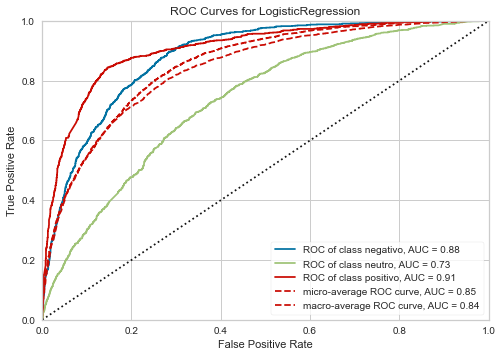

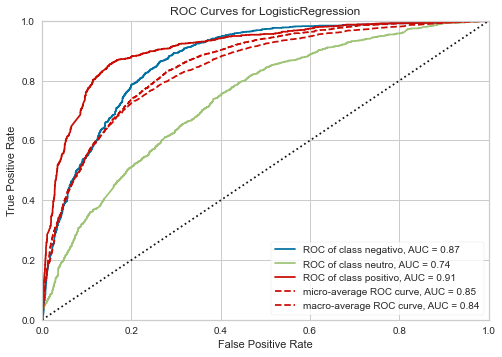

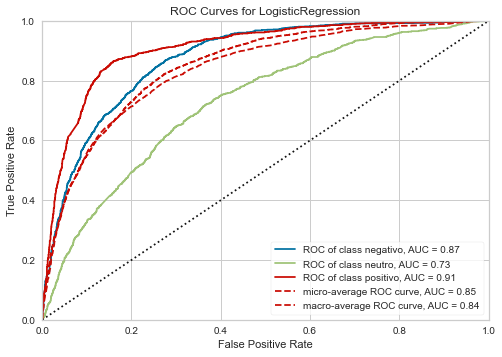

In [5]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})

# Criando um undersampling para balancear a base de treino e teste
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_res, y_res)
i = 1

for train_index, test_index in skf.split(X_res, y_res):
    X_train, X_test = X_res[train_index], X_res[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(penalty='l2',C=0.26676706993743576, class_weight=None, solver='sag', multi_class='multinomial',max_iter=100)

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    plt.figure(i)
    visualizer = ROCAUC(regressao_logistica)

    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and render the figure
    i += i

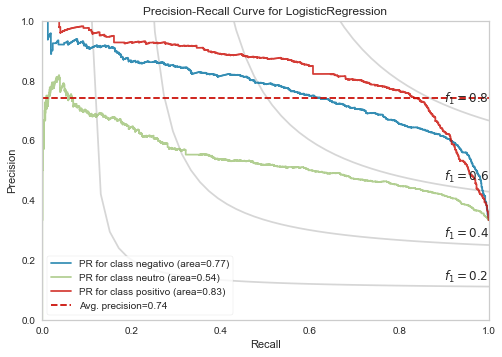

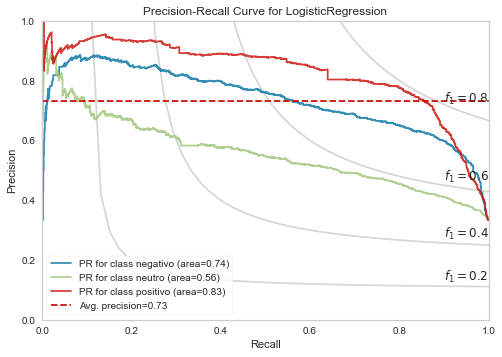

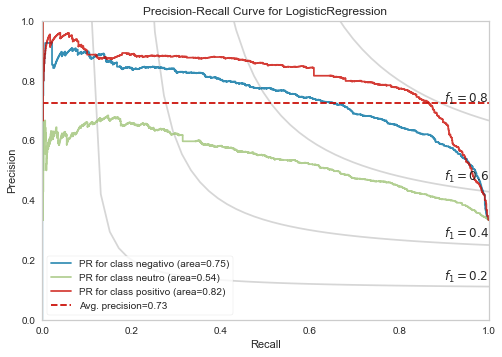

In [6]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})

# Criando um undersampling para balancear a base de treino e teste
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

encoder = LabelEncoder()
y_encoder = encoder.fit_transform(y_res)

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_res, y_encoder)
i = 1

for train_index, test_index in skf.split(X_res, y_encoder):
    X_train, X_test = X_res[train_index], X_res[test_index]
    y_train, y_test = y_encoder[train_index], y_encoder[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(penalty='l2',C=0.26676706993743576, class_weight=None, solver='sag', multi_class='multinomial',max_iter=100)

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    plt.figure(i)
    # Create the visualizer, fit, score, and show it
    viz = PrecisionRecallCurve(
        regressao_logistica,
        classes=encoder.classes_,
            iso_f1_curves=True,
            per_class=True,
            micro=False
    )
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()                     # Finalize and render the figure
    i += i

#### 7.1.4. Otimizando os Hiperparamêntros do modelo SVC

In [3]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})

# Criando um undersampling para balancear a base de treino e teste
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Hiperparâmentros
tuned_parameters = {
    'C': [1, 50, 100, 150],
    'kernel' : ['rbf'],
    'gamma': [0.1, 5] 
}

model_SVC = SVC()
incial = time()
print_score(model_SVC, X_res, y_res, tuned_parameters)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros para make_scorer(f1_score, average=micro)

Melhor conjunto de parâmetros encontrado: 

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.668 (+/-0.008) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.541 (+/-0.069) for {'C': 1, 'gamma': 5, 'kernel': 'rbf'}
0.636 (+/-0.011) for {'C': 50, 'gamma': 0.1, 'kernel': 'rbf'}
0.559 (+/-0.055) for {'C': 50, 'gamma': 5, 'kernel': 'rbf'}
0.628 (+/-0.017) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.559 (+/-0.055) for {'C': 100, 'gamma': 5, 'kernel': 'rbf'}
0.626 (+/-0.017) for {'C': 150, 'gamma': 0.1, 'kernel': 'rbf'}
0.559 (+/-0.055) for {'C': 150, 'gamma': 5, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.69      0.74      0.72       711
      neutro       0.58      0.53      0.55       710
    positivo       0.79      0.80      0.79       708

    accuracy          

In [4]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})

# Criando um undersampling para balancear a base de treino e teste
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Hiperparâmentros
tuned_parameters = {
    'C': [0.1, 1, 5, 10],
    'kernel' : ['rbf'],
    'gamma': [0.1, 0.5, 1] 
}

model_SVC = SVC()
incial = time()
print_score(model_SVC, X_res, y_res, tuned_parameters)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros para make_scorer(f1_score, average=micro)

Melhor conjunto de parâmetros encontrado: 

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.609 (+/-0.024) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.639 (+/-0.020) for {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}
0.632 (+/-0.019) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.668 (+/-0.012) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.672 (+/-0.011) for {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.674 (+/-0.017) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.666 (+/-0.015) for {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
0.651 (+/-0.015) for {'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}
0.654 (+/-0.012) for {'C': 5, 'gamma': 1, 'kernel': 'rbf'}
0.657 (+/-0.015) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.642 (+/-0.013) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.649 (+/-0.014) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:


### 7.2. NearMiss-2

NearMiss adiciona algumas regras heurísticas para selecionar amostras. As regras heurísticas são baseadas no algoritmo dos vizinhos mais próximos. Portanto, os parâmetros n_neighbors e o n_neighbors_ver3 são derivados KNeighborsMixin de scikit-learn. O primeiro parâmetro é usado para calcular a distância média aos vizinhos enquanto o segundo é usado para a pré-seleção das amostras de interesse.

O NearMiss-2 seleciona as amostras pertencentes à classe alvo a ser subamostrada para as quais a distância média para as N-amostras mais distantes da amostras da classe minoritária (ou seja, a classe mais sub-representada) é a menor.

In [7]:
from imblearn.under_sampling import NearMiss

In [14]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    nm1 = NearMiss(version=2)
    X_resampled, y_resampled = nm1.fit_resample(X_train, y_train)   


    lr_clf = make_pipeline(
    LogisticRegression(solver = "saga", multi_class='multinomial', max_iter=300),
    )

    lr_clf.fit(X_resampled, y_resampled)
    y_true, y_pred = y_test, lr_clf.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.793566224084749
              precision    recall  f1-score   support

    negativo       0.78      0.72      0.75      3627
      neutro       0.21      0.47      0.29      1182
    positivo       0.95      0.82      0.88      8797

    accuracy                           0.76     13606
   macro avg       0.65      0.67      0.64     13606
weighted avg       0.84      0.76      0.79     13606

f1_score: 0.7957706657852145
              precision    recall  f1-score   support

    negativo       0.78      0.73      0.75      3626
      neutro       0.21      0.46      0.29      1183
    positivo       0.95      0.82      0.88      8797

    accuracy                           0.77     13606
   macro avg       0.65      0.67      0.64     13606
weighted avg       0.84      0.77      0.80     13606

f1_score: 0.7954580884098367
              precision    recall  f1-score   support

    negativo       0.77      0.72      0.75      3626
      neutro       0.22      0.48      0.30

In [8]:
# Definindo X e y
X = corpus_features
y = dataset['sentiment_label'].map({-1: 'negativo', 0: 'neutro', 1: 'positivo'})


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    nm1 = NearMiss(version=2)
    X_resampled, y_resampled = nm1.fit_resample(X_train, y_train)   


    lr_clf = make_pipeline(
    SVC(C=110, gamma=0.1, kernel='rbf')
    )

    lr_clf.fit(X_resampled, y_resampled)
    y_true, y_pred = y_test, lr_clf.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.757095328840229
              precision    recall  f1-score   support

    negativo       0.73      0.69      0.71      3627
      neutro       0.18      0.44      0.25      1182
    positivo       0.94      0.77      0.85      8797

    accuracy                           0.72     13606
   macro avg       0.61      0.63      0.60     13606
weighted avg       0.81      0.72      0.76     13606

f1_score: 0.761339176336095
              precision    recall  f1-score   support

    negativo       0.73      0.69      0.71      3626
      neutro       0.18      0.44      0.26      1183
    positivo       0.94      0.78      0.85      8797

    accuracy                           0.73     13606
   macro avg       0.62      0.64      0.61     13606
weighted avg       0.82      0.73      0.76     13606

f1_score: 0.761379271012861
              precision    recall  f1-score   support

    negativo       0.73      0.68      0.71      3626
      neutro       0.18      0.45      0.26  

## 8. Conclusão

Após verificar todas as métricas (precision,recall e f1-score) e o plot das curvas (ROC e PrecisionRecallCurve) verificamos que para esta série de tratamentos e tecnicas realizados ao conjunto de dados a classificação da classe "Neutro" não assume valores bons suficientes para validar o modelo. Então vamos alterar as classes para o proceso de classificação. O modelo irá classificar os comentários em duas classes: "Other" e "Negativo", onde o novo objetivo do projeto será diferenciar os comentários negativos das demais classes. O conjunto de comentários negativos possui um alto valor de informação para empresas, podendo ser utilizado como feedback de melhoria e/ou base de dados para análise de causa raiz.